In [16]:
import gym_bandits
import gym
import numpy as np
import random

In [181]:
class BanditAgent():
    def __init__(self, epsilon):
        
        self.epsilon = epsilon
        
        self.rewardsPerAction = np.array([
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0
        ])
        self.actionCounts = np.array([
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0
        ])
    
    def Q(self, a):
        if self.actionCounts[a] == 0:
            return 0
        
        estimated_value = self.rewardsPerAction[a] / self.actionCounts[a]
        return estimated_value
    
    def getAllValueEstimates(self):
        
        estimates = np.zeros((9,))
        for action in range(len(estimates)):
            estimates[action] = self.Q(action)
        
        return estimates
        
    
    def greedy_policy(self):
        action = np.argmax(self.getAllValueEstimates())
        return action
    
    def e_greedy_policy(self):
        if random.random() < self.epsilon:
            return random.randint(0, 9)
        else:
            return self.greedy_policy()
    
    def train(self, action_taken, reward):
        self.rewardsPerAction[action_taken] += reward
        self.actionCounts += 1

In [182]:
env = gym.make("BanditTenArmedGaussian-v0")
env.reset()

0

In [183]:
game_length = 1000
agent = BanditAgent(0.1)

rewards = []

for i in range(game_length):
    action = agent.e_greedy_policy()
    _, reward, _, _ = env.step(action)
    agent.train(action, reward)
    rewards.append(reward)

In [184]:
from matplotlib import pyplot as plt

1.4012822058264642

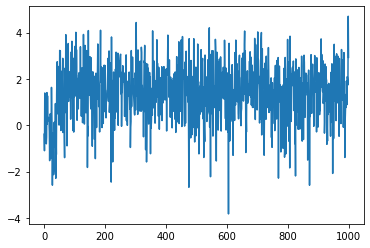

In [185]:
plt.plot(rewards)
np.mean(rewards)

In [186]:
env.r_dist

[[-0.5274012605367359, 1],
 [0.33988592690608777, 1],
 [-0.06911060636758455, 1],
 [0.034932909457146256, 1],
 [-0.5439189551154788, 1],
 [-1.0283341666613361, 1],
 [0.09527434278038478, 1],
 [1.6525770606498873, 1],
 [-0.5213330885605079, 1],
 [-1.8673830328869456, 1]]